### __NLP Disaster Tweets: Sentiment Analysis with Pre-trained Model, Vader__

NLP Reference Links:
> - https://pub.towardsai.net/ai-sustainability-tweets-sentiment-analysis-using-pre-trained-models-8669f8ba70ed
> - NLTK Library of Pre-trained Models: http://www.nltk.org/nltk_data/
> - GitHub for Vedar: https://github.com/cjhutto/vaderSentiment

Other Reference Links:
> - https://www.interviewqs.com/ddi-code-snippets/drop-duplicate-rows-pandas



In [ ]:
!pip install matplotlib --upgrade

     |████████████████████████████████| 11.2 MB 15.1 MB/s 
     |████████████████████████████████| 930 kB 59.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time

import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

# to be able to see multiple ouputs from sungle cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### __Load Datasets__
  * Only using train data, as it is labeled (i.e. disaster- or non-disaster related tweets), while test data is not labeled

In [ ]:
# import train data
train_df = pd.read_csv('/content/train.csv')
train_df.info()
train_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


#### __Pre-Trained Model: Vader_Lexicon__

In [ ]:
#nltk.download()
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
# test sentiment analysis
text_test = train_df['text'][0]
print(f'\n{text_test}\n')
sentiment.polarity_scores(text_test)


Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all



{'compound': 0.2732, 'neg': 0.0, 'neu': 0.851, 'pos': 0.149}

In [ ]:
# function to convert dictionary output to list output
def dict_converter(dict1):
  dictlist = list()
  for key, value in dict1.items():
    temp = [key,value]
    dictlist.append(temp)
  return dictlist

#example
dict_converter({'compound': 0.2732, 'neg': 0.0, 'neu': 0.851, 'pos': 0.149})

[['compound', 0.2732], ['neg', 0.0], ['neu', 0.851], ['pos', 0.149]]

In [ ]:
dict_converter({'compound': 0.2732, 'neg': 0.0, 'neu': 0.851, 'pos': 0.149})[0][1]

0.2732

#### __Sentiment Analysis__

In [ ]:
# start time to measure the time of the program execution
start_time = time.time()

tweets = list()

for g in train_df['text']:
  dict_res = dict_converter(sentiment.polarity_scores(g))
  tweets.append([g, dict_res[0][1], dict_res[1][1], dict_res[2][1], dict_res[3][1]])

# make tweets lists above to datarame
tweets = pd.DataFrame(tweets, columns=['text', 'neg', 'neu', 'pos', 'compound'])
tweets.info()
tweets

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   text      7613 non-null   object 
 1   neg       7613 non-null   float64
 2   neu       7613 non-null   float64
 3   pos       7613 non-null   float64
 4   compound  7613 non-null   float64
dtypes: float64(4), object(1)
memory usage: 297.5+ KB


,text,neg,neu,pos,compound
0,Our Deeds are the Reason of this #earthquake M...,0.000,0.851,0.149,0.2732
1,Forest fire near La Ronge Sask. Canada,0.286,0.714,0.000,-0.3400
2,All residents asked to 'shelter in place' are ...,0.095,0.905,0.000,-0.2960
3,"13,000 people receive #wildfires evacuation or...",0.000,1.000,0.000,0.0000
4,Just got sent this photo from Ruby #Alaska as ...,0.000,1.000,0.000,0.0000
...,...,...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,0.262,0.738,0.000,-0.4939
7609,@aria_ahrary @TheTawniest The out of control w...,0.166,0.834,0.000,-0.5849
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,0.000,1.000,0.000,0.0000
7611,Police investigating after an e-bike collided ...,0.345,0.655,0.000,-0.7845




--- 1.4730522632598877 seconds ---


In [ ]:
# start time to measure the time of the program execution
start_time = time.time()

# Add the result of sentiment analysis to train data
train_df['sentiment_neg'] = tweets['neg']
train_df['sentiment_neu'] = tweets['neu']
train_df['sentiment_pos'] = tweets['pos']
train_df['sentiment_compound'] = tweets['compound']

# check
train_df.info()
train_df

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  7613 non-null   int64  
 1   keyword             7552 non-null   object 
 2   location            5080 non-null   object 
 3   text                7613 non-null   object 
 4   target              7613 non-null   int64  
 5   sentiment_neg       7613 non-null   float64
 6   sentiment_neu       7613 non-null   float64
 7   sentiment_pos       7613 non-null   float64
 8   sentiment_compound  7613 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 535.4+ KB


,id,keyword,location,text,target,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.000,0.851,0.149,0.2732
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.286,0.714,0.000,-0.3400
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.095,0.905,0.000,-0.2960
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.000,1.000,0.000,0.0000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,0.262,0.738,0.000,-0.4939
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,0.166,0.834,0.000,-0.5849
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,0.000,1.000,0.000,0.0000
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,0.345,0.655,0.000,-0.7845




--- 0.028035879135131836 seconds ---


In [ ]:
# drop duplicate tweets and check shape before/after

# start time to measure the time of the program execution
start_time = time.time()

# before dropping duplicates
print('\n', train_df.shape)
print('\n')

# drop a duplicate row, based on column name
train_df = train_df.drop_duplicates(subset='text', keep="first")

# after dropping duplicates
print('\n', train_df.shape)

# check
train_df.info()
train_df

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")


 (7613, 9)



 (7503, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 0 to 7612
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  7503 non-null   int64  
 1   keyword             7447 non-null   object 
 2   location            5021 non-null   object 
 3   text                7503 non-null   object 
 4   target              7503 non-null   int64  
 5   sentiment_neg       7503 non-null   float64
 6   sentiment_neu       7503 non-null   float64
 7   sentiment_pos       7503 non-null   float64
 8   sentiment_compound  7503 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 586.2+ KB


,id,keyword,location,text,target,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.000,0.851,0.149,0.2732
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.286,0.714,0.000,-0.3400
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.095,0.905,0.000,-0.2960
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.000,1.000,0.000,0.0000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1,0.249,0.751,0.000,-0.6841
7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1,0.122,0.878,0.000,-0.4939
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,0.328,0.574,0.098,-0.7650
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,0.262,0.738,0.000,-0.4939




--- 0.03233671188354492 seconds ---


#### __Order Tweets by the scores from the most positive to the most negative__

In [ ]:
# start time to measure the time of the program execution
start_time = time.time()

train_df = train_df.sort_values(['sentiment_compound'], ascending=False)
train_df

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

,id,keyword,location,text,target,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
6992,10028,twister,NaN,Check out 'Want Twister Tickets AND A VIP EXPE...,0,0.000,0.402,0.598,0.9730
6534,9345,survived,"Texas, USA",@thoutaylorbrown I feel like accidents are jus...,0,0.049,0.412,0.539,0.9564
6292,8989,storm,NaN,TodayÛªs storm will pass; let tomorrowÛªs li...,1,0.000,0.509,0.491,0.9471
3163,4541,emergency,"Renfrew, Scotland",@batfanuk we enjoyed the show today. Great fun...,0,0.084,0.354,0.563,0.9423
6778,9710,tragedy,NaN,Maaaaan I love Love Without Tragedy by @rihann...,0,0.000,0.381,0.619,0.9394
...,...,...,...,...,...,...,...,...,...
6407,9159,suicide%20bomber,Worldwide,17 killed in SÛªArabia mosque suicide bombing...,1,0.579,0.421,0.000,-0.9552
6393,9137,suicide%20bomb,Worldwide,? 19th Day Since 17-Jul-2015 -- Nigeria: Suici...,1,0.583,0.417,0.000,-0.9595
6411,9166,suicide%20bomber,NaN,Suicide bomber kills 15 in Saudi security site...,1,0.536,0.400,0.064,-0.9623
6414,9172,suicide%20bomber,NaN,@Abu_Baraa1 Suicide bomber targets Saudi mosqu...,1,0.542,0.458,0.000,-0.9686




--- 0.01981806755065918 seconds ---


In [ ]:
print(f"Min: {min(train_df['sentiment_compound'])}")
print(f"Max: {max(train_df['sentiment_compound'])}")

Min: -0.9883
Max: 0.973


In [ ]:
# start time to measure the time of the program execution
start_time = time.time()

# count the positive, neutral and negative sentiment
sentiment = []

for score in train_df['sentiment_compound']:
  if score >= 0.05:
    sentiment.append('positive')
  elif score <= -0.05:
    sentiment.append('negative')
  else:
    sentiment.append('neutral')

train_df['sentiment'] = sentiment

# check
train_df.info()
train_df

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 6992 to 7472
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  7503 non-null   int64  
 1   keyword             7447 non-null   object 
 2   location            5021 non-null   object 
 3   text                7503 non-null   object 
 4   target              7503 non-null   int64  
 5   sentiment_neg       7503 non-null   float64
 6   sentiment_neu       7503 non-null   float64
 7   sentiment_pos       7503 non-null   float64
 8   sentiment_compound  7503 non-null   float64
 9   sentiment           7503 non-null   object 
dtypes: float64(4), int64(2), object(4)
memory usage: 644.8+ KB


,id,keyword,location,text,target,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound,sentiment
6992,10028,twister,NaN,Check out 'Want Twister Tickets AND A VIP EXPE...,0,0.000,0.402,0.598,0.9730,positive
6534,9345,survived,"Texas, USA",@thoutaylorbrown I feel like accidents are jus...,0,0.049,0.412,0.539,0.9564,positive
6292,8989,storm,NaN,TodayÛªs storm will pass; let tomorrowÛªs li...,1,0.000,0.509,0.491,0.9471,positive
3163,4541,emergency,"Renfrew, Scotland",@batfanuk we enjoyed the show today. Great fun...,0,0.084,0.354,0.563,0.9423,positive
6778,9710,tragedy,NaN,Maaaaan I love Love Without Tragedy by @rihann...,0,0.000,0.381,0.619,0.9394,positive
...,...,...,...,...,...,...,...,...,...,...
6407,9159,suicide%20bomber,Worldwide,17 killed in SÛªArabia mosque suicide bombing...,1,0.579,0.421,0.000,-0.9552,negative
6393,9137,suicide%20bomb,Worldwide,? 19th Day Since 17-Jul-2015 -- Nigeria: Suici...,1,0.583,0.417,0.000,-0.9595,negative
6411,9166,suicide%20bomber,NaN,Suicide bomber kills 15 in Saudi security site...,1,0.536,0.400,0.064,-0.9623,negative
6414,9172,suicide%20bomber,NaN,@Abu_Baraa1 Suicide bomber targets Saudi mosqu...,1,0.542,0.458,0.000,-0.9686,negative




--- 0.028116941452026367 seconds ---


In [ ]:
# export train data with sentiment analysis above
train_df.to_csv('sentiment_train_data.csv', index=False)

In [ ]:
train_df['sentiment'].value_counts()
print('\n')
train_df['sentiment'].value_counts()/len(train_df)

positive_num = (train_df['sentiment'].value_counts())[2]
neutral_num = (train_df['sentiment'].value_counts())[1]
negative_num = (train_df['sentiment'].value_counts())[0]

positive = (train_df['sentiment'].value_counts()/len(train_df))[2]
neutral = (train_df['sentiment'].value_counts()/len(train_df))[1]
negative = (train_df['sentiment'].value_counts()/len(train_df))[0]

print(f'\n\nPositive Tweets: {round(positive*100,2)} % | \
Neutral Tweets: {round(neutral*100,2)} % | \
Negative Tweets: {round(negative*100,2)} %')

negative    3646
neutral     1990
positive    1867
Name: sentiment, dtype: int64

negative    0.485939
neutral     0.265227
positive    0.248834
Name: sentiment, dtype: float64



Positive Tweets: 24.88 % | Neutral Tweets: 26.52 % | Negative Tweets: 48.59 %


<Figure size 720x720 with 0 Axes>

Text(0, 0.5, '%')

Text(0.5, 1.0, 'Sentiments in Disaster Tweets')

[Text(0, 0, '24.88'), Text(0, 0, '26.52'), Text(0, 0, '48.59')]

<Figure size 720x720 with 0 Axes>

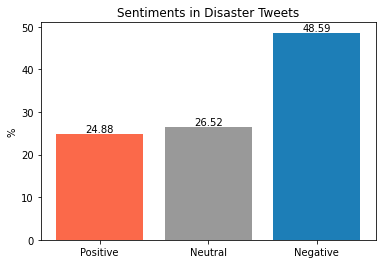



--- 0.1672065258026123 seconds ---


In [ ]:
# Plot Bar Plot of Sentiment

# start time to measure the time of the program execution
start_time = time.time()

plt.figure(figsize=(10,10))
fig, ax = plt.subplots()

# creating the dataset
data = {'Positive': round(positive*100, 2), 'Neutral': round(neutral*100, 2),
        'Negative': round(negative*100, 2)}
classes = list(data.keys())
values = list(data.values())

cmap_red = plt.cm.get_cmap('Reds')
red = cmap_red(0.5)

cmap_gray = plt.cm.get_cmap('gray')
gray = cmap_gray(0.6)

cmap_org = plt.cm.get_cmap('GnBu')
blue = cmap_org(0.8)

p1 = ax.bar(classes, values, color=[red, gray, blue])
ax.set_ylabel('%')
ax.set_title('Sentiments in Disaster Tweets')
ax.set_xticks(classes)

# Label with label_type 'center' instead of the default 'edge'
ax.bar_label(p1)

plt.show()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<Figure size 720x720 with 0 Axes>

Text(0, 0.5, 'Number of Tweets')

Text(0.5, 1.0, 'Sentiments in Disaster Tweets')

[Text(0, 0, '1867'), Text(0, 0, '1990'), Text(0, 0, '3646')]

<Figure size 720x720 with 0 Axes>

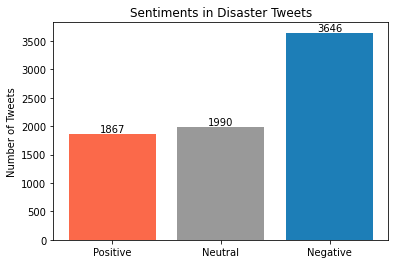



--- 0.16961431503295898 seconds ---


In [ ]:
# Plot Bar Plot of Sentiment

# start time to measure the time of the program execution
start_time = time.time()

plt.figure(figsize=(10,10))
fig, ax = plt.subplots()

# creating the dataset
data = {'Positive': positive_num, 'Neutral': neutral_num,
        'Negative': negative_num}
classes = list(data.keys())
values = list(data.values())

cmap_red = plt.cm.get_cmap('Reds')
red = cmap_red(0.5)

cmap_gray = plt.cm.get_cmap('gray')
gray = cmap_gray(0.6)

cmap_org = plt.cm.get_cmap('GnBu')
blue = cmap_org(0.8)

p1 = ax.bar(classes, values, color=[red, gray, blue])
ax.set_ylabel('Number of Tweets')
ax.set_title('Sentiments in Disaster Tweets')
ax.set_xticks(classes)

# Label with label_type 'center' instead of the default 'edge'
ax.bar_label(p1)

plt.show()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

In [40]:
train_df['count'] = 1
train_df.info()
train_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7503 entries, 0 to 7502
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  7503 non-null   int64  
 1   keyword             7447 non-null   object 
 2   location            5021 non-null   object 
 3   text                7503 non-null   object 
 4   target              7503 non-null   int64  
 5   sentiment_neg       7503 non-null   float64
 6   sentiment_neu       7503 non-null   float64
 7   sentiment_pos       7503 non-null   float64
 8   sentiment_compound  7503 non-null   float64
 9   sentiment           7503 non-null   object 
 10  count               7503 non-null   int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 644.9+ KB


,id,keyword,location,text,target,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound,sentiment,count
0,10028,twister,NaN,Check out 'Want Twister Tickets AND A VIP EXPE...,0,0.000,0.402,0.598,0.9730,positive,1
1,9345,survived,"Texas, USA",@thoutaylorbrown I feel like accidents are jus...,0,0.049,0.412,0.539,0.9564,positive,1
2,8989,storm,NaN,TodayÛªs storm will pass; let tomorrowÛªs li...,1,0.000,0.509,0.491,0.9471,positive,1


In [41]:
# start time to measure the time of the program execution
start_time = time.time()

summary_pivot = pd.pivot_table(train_df, values=['count', 'sentiment_compound'],
                               index=['target', 'sentiment'],
                               aggfunc={'count': np.sum,
                                        'sentiment_compound': np.mean})
summary_pivot = summary_pivot.reset_index()
summary_pivot

train_df = train_df.drop(['count'], axis=1)
train_df.head(3)

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

,target,sentiment,count,sentiment_compound
0,0,negative,1827,-0.498795
1,0,neutral,1128,0.000265
2,0,positive,1350,0.483374
3,1,negative,1819,-0.581580
4,1,neutral,862,-0.000213
5,1,positive,517,0.412344


,id,keyword,location,text,target,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound,sentiment
0,10028,twister,NaN,Check out 'Want Twister Tickets AND A VIP EXPE...,0,0.000,0.402,0.598,0.9730,positive
1,9345,survived,"Texas, USA",@thoutaylorbrown I feel like accidents are jus...,0,0.049,0.412,0.539,0.9564,positive
2,8989,storm,NaN,TodayÛªs storm will pass; let tomorrowÛªs li...,1,0.000,0.509,0.491,0.9471,positive




--- 0.02751469612121582 seconds ---


<Figure size 720x576 with 0 Axes>

[Text(0, 0, '1827'), Text(0, 0, '1128'), Text(0, 0, '1350')]

[Text(0, 0, '1819'), Text(0, 0, '862'), Text(0, 0, '517')]



--- 0.04410362243652344 seconds ---


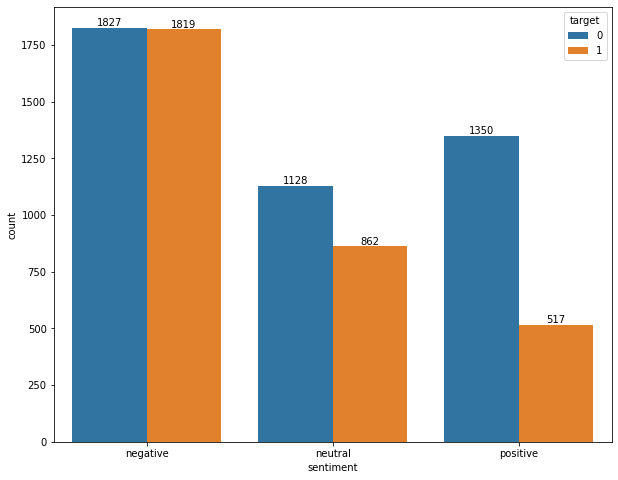

In [42]:
# Plot Bar Plot of Sentiment

# start time to measure the time of the program execution
start_time = time.time()

plt.figure(figsize=(10,8))

ax = sns.barplot(x='sentiment', y='count', hue='target', 
                 data=summary_pivot)
for container in ax.containers:
    ax.bar_label(container)

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<Figure size 720x576 with 0 Axes>

[Text(0, 0, '-0.498795'), Text(0, 0, '0.000264805'), Text(0, 0, '0.483374')]

[Text(0, 0, '-0.58158'), Text(0, 0, '-0.000213109'), Text(0, 0, '0.412344')]



--- 0.044054508209228516 seconds ---


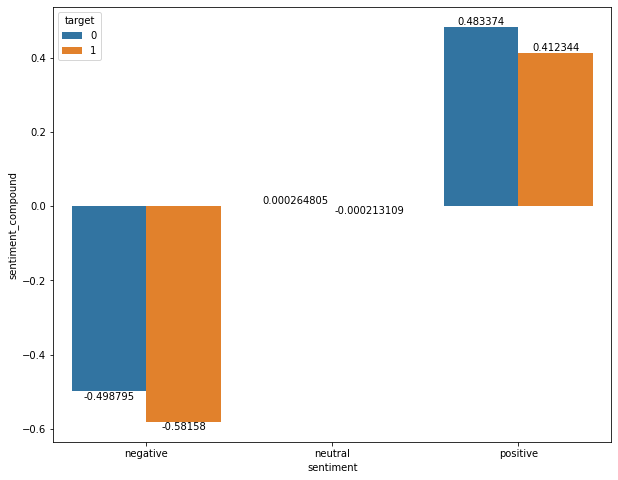

In [43]:
# Plot Bar Plot of Sentiment

# start time to measure the time of the program execution
start_time = time.time()

plt.figure(figsize=(10,8))

ax = sns.barplot(x='sentiment', y='sentiment_compound', hue='target', 
                 data=summary_pivot)
for container in ax.containers:
    ax.bar_label(container)

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<AxesSubplot:xlabel='sentiment_compound', ylabel='Count'>

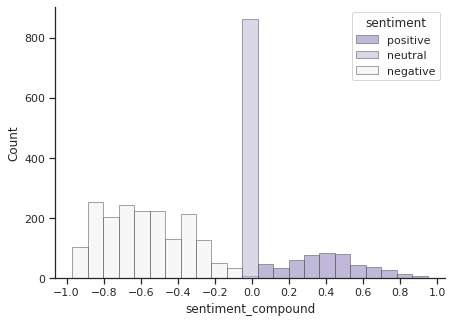

In [51]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

train_disaster = train_df[train_df['target']==1]

sns.histplot(
    train_disaster,
    x="sentiment_compound", 
    hue="sentiment",
    #multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([-1, -0.80, -0.6, -0.4, -0.2, 0,
               0.2, 0.4, 0.6, 0.8, 1])

<AxesSubplot:xlabel='sentiment_compound', ylabel='Count'>

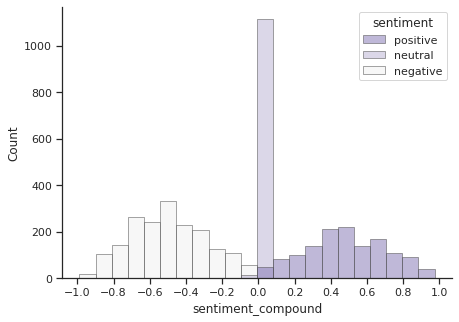

In [52]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

train_nondisaster = train_df[train_df['target']==0]

sns.histplot(
    train_nondisaster,
    x="sentiment_compound", 
    hue="sentiment",
    #multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([-1, -0.80, -0.6, -0.4, -0.2, 0,
               0.2, 0.4, 0.6, 0.8, 1])